Run the following cell to force the stdout results appear on your terminal.
This prevents your notebook of gettin cluterred with the logs of the software executed in background.

In [1]:
import sys
import os

In [2]:
import logging

logging.basicConfig(level=logging.ERROR)  # Only show ERROR messages and above

import warnings
warnings.filterwarnings("ignore")

In [3]:
from settings import *

## Importing essential Python Packages

In [4]:
sys.path.insert(0, PYSBF_PATH)

import warnings
from pysbf import *
from IPython.display import display, Markdown, clear_output

%matplotlib widget
warnings.filterwarnings('ignore')

## Installing Required Python Packages ..

- **Note:** If this is your first time running this notebook, check the following box to install all required python packages.

## Object Initialization

In [5]:
box_new = widgets.Checkbox(description='Force New Session', value = False)
box_new

Checkbox(value=False, description='Force New Session')

### Force New

- Set to `True` (check the above box) to generate a new working session. All parameters would be reset to default values, and all output files would be stored in a new folder with the same name.

- Default is `False`, if the session doesn't exist, it creates a new one, otherwise it starts from lastest parameters stored in the logfile and continues saving outputs in the same folder as the existing sessin.

In [6]:
name = "u12517"

In [7]:
obj = SBFobject(name, 
                inFolder=IN_FOLDER, 
                outFolder=OUT_FOLDER,
                config=CONFIG_FOLDER, 
                force_new=box_new.value)

Creating output folder:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35


In [8]:
s = obj.slider_back_threshold()

widgets.HBox(s)

Background Median: 3607
Background Mean: 3607
Background Stdev: 123
fig. name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_initial_back.png


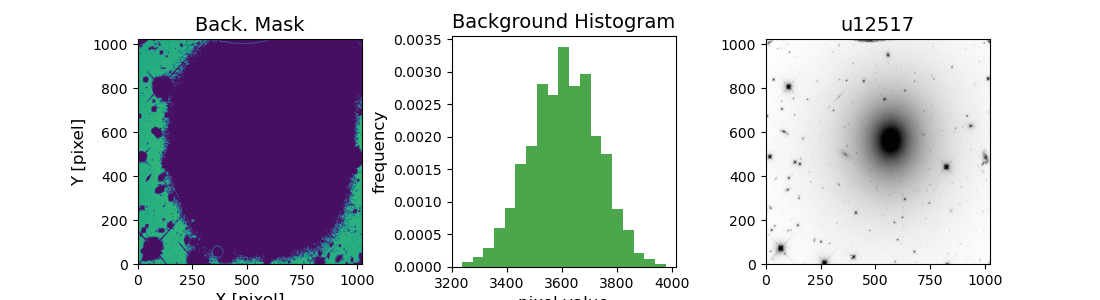

In [9]:
_ = obj.plot_back_mask()

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

In [10]:
widget = obj.slider_naive_extractor()

widgets.HBox(widget)

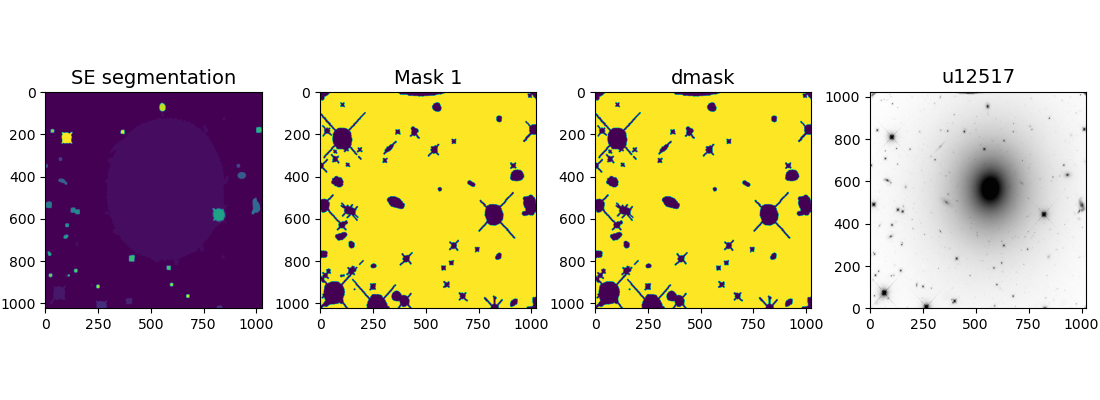

In [11]:
axes = obj.plot_naives_source_extract()

## Running Elliprof

Here, we run `elliprof` for the firt time. The initial mask that was generated above (e.g. mask=1) is utilized here and `model=0` is created. Usually, the Kron_radius factor is set to a value greater than 2 and smaller than 4.
The main goal is to generate very crude model.

- `r0`: Inner radius to fit
- `r1`: Outer radius to fit, i.e. `obj.outerR(c_kron)`, where `outerR` takes the Kron radius factor and converts it to number of pixels
- `c_kron`: Kron radius factor
- `sky`: sky value, which is roughly about 90% of the median of the values of the background pixels. *Note:* The sky level would be fine tuned later.
- `k`: A factor to determine the number of fitting radii, i.e. `nr=(r1-r0)/k`
- `options`: Any other that `elliprof` accepts. 


**Note:** The following sliders control parameters for the inital run of elliprof

In [12]:
widget = obj.basic_elliprof_widget()

widgets.VBox(widget)

N_cross: 0
r0: 9
r1: 347
nr: 23
sky: 3246
fig. name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35//u12517_basic_model.png


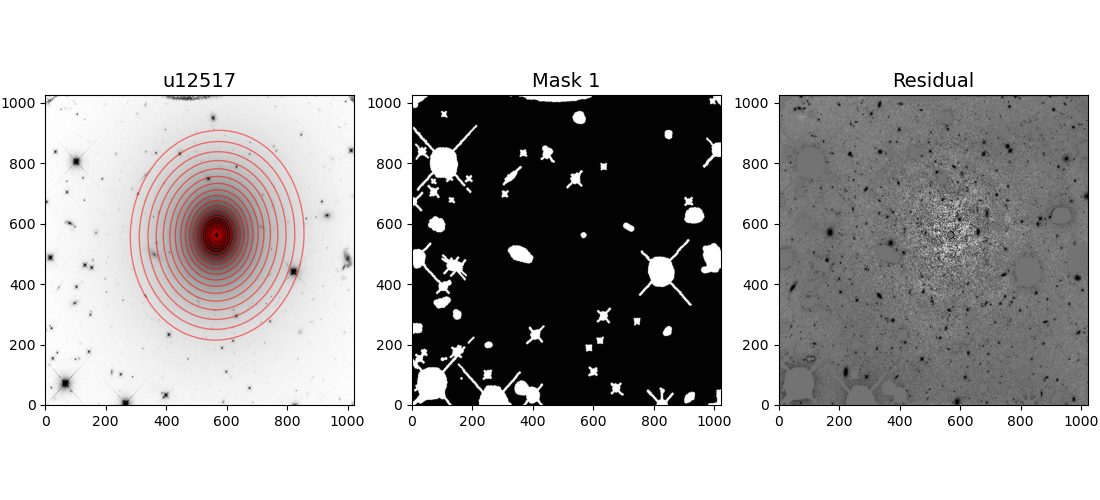

In [13]:
_ = obj.basic_elliprof()

## Second round of elliprof

Here, we use the primary model that we generated in the previous cell to cover the masked regions.
Then we run Source Extractor for additional mask. The residuals of model=0 is used to create another mask. The initial mask can be further augmented with the mask we generate here.

- `model=0`: initial profile model from the previous cell. The masked regions are replaced by this model
- `model_mask`: the model that is used to patch the masked regions

**Top**
- Left: Red ellipse displays the galaxy border defined by Kron radius

**Notes:**

- Left Slider: Parameter to creat elliprof models

- Right Slider: Parameters to run Source Extractor on the residual image for the purpose of generating additonal mask, i.e. `mask=2`

- Sometimes, one has to iteratively gnerate `mask=2` and combine it with `mask1`. The resutls would be always stored in `mask=1`.

In [14]:
s1, s2 = obj.second_elliprof_widget()

box1 = widgets.VBox(s1)
box2 = widgets.VBox(s2)

widgets.HBox([box1,box2])

fig. name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35//u12517_initial_model.png


Checkbox(value=False, description='Combine Mask')

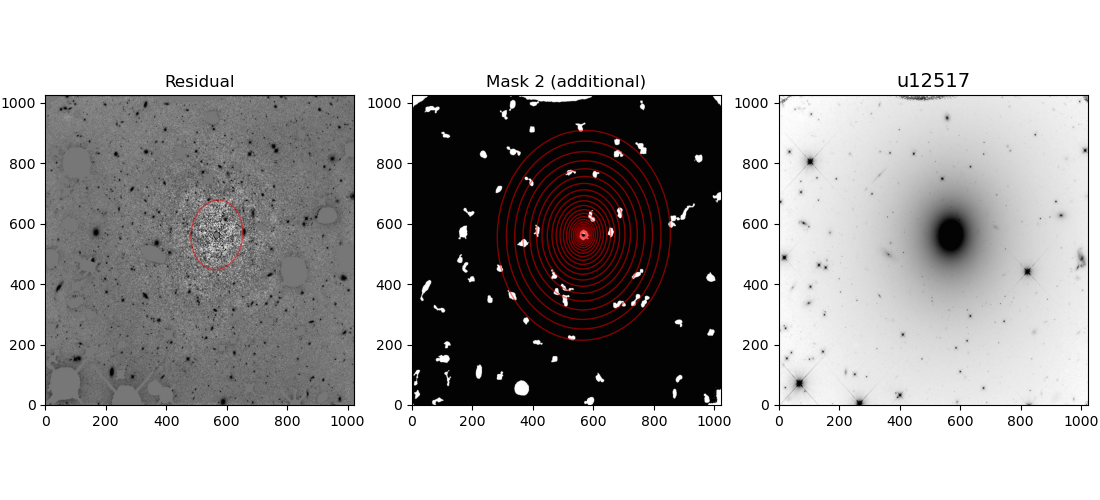

In [15]:
_ = obj.second_elliprof()

checkbox = widgets.Checkbox(description='Combine Mask', value = False)
checkbox

**Note:** Use the above checkbox if you want to combine masks. This box always gets deactived when a new additiona mask (`mask=2`) is generated.

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [16]:
# combining mask1 and mask2 ----> mask1
if checkbox.value==True:
    obj.addMasks(maskList=[1,2], mask=1)

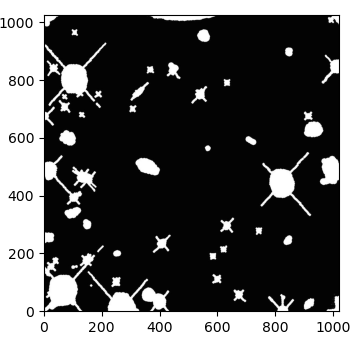

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ax = plt.gca()
obj.tv_mask(mask=1, ax=ax)

pngName = obj.objRoot+'/'+obj.name+'_combined_mask.png'
plt.savefig(pngName)
fig.tight_layout(pad=0)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [18]:
## Updating background level?

option = obj.params["second_elliprof"]["option"]
c_kron = obj.params["second_elliprof"]["c_kron"]
k = obj.params["second_elliprof"]["k_ellipse"]

r0         = obj.params["second_elliprof"]["r0"] 
r1         = obj.outerR(c_kron)      
nr         = int(np.round((r1-r0)/k))
initial_sky_factor = obj.params["second_elliprof"]["sky_factor"]

# model #: the elliprof model id
optimized_sky_factor = obj.optimize_sky_factor(initial_sky_factor, r0, r1, nr, options=option, model=999)   

print("Optimized sky factor: ", "%.3f"%optimized_sky_factor)


Optimized sky factor:  0.895


### Optimizing Sky Factor  with different input parameters

The following block runs the optimziation code using various input parameters chosen randomly 
and each time returns the optimzized `sky_factor`

In [19]:
sky_optimize = widgets.Checkbox(description='Iterative Sky Oprtimizations', value = False)
sky_optimize

Checkbox(value=False, description='Iterative Sky Oprtimizations')

### Itereative Sky Optimization

- Check the box to execute the following cell. 
- The following cell randomly draw input parameters, runs elliprof and optimizes the sky factor for each model.

**Free Parameters:**

- `n_iterations`: The number of iterations
- `max_ellipse_crossing`: Maximum number of allowed ellipse intersections


In [20]:
n_iterations = 4*2          # 4*n (multiple of 4)
max_ellipse_crossing = 3

fmt_dict = {}
key_list = []
def dict_append(myDict, key, value, fmt):
    
    if key in myDict:
        myDict[key].append(value)
        fmt_dict[key].append(fmt)
    else:
        myDict[key] = [value]
        fmt_dict[key] = [fmt]
        key_list.append(key)

    return myDict
    
outDict = {}
df = None
csv_name = obj.objRoot+'/'+obj.name+'_iterative_sky_optimizer.csv'
s= ""

if sky_optimize.value:
    
    i = 1

    print("i, r0, r1, nr, n_cross, initial_sky_factor, final_sky_factor")

    while i<=n_iterations:

        c_kron = obj.params["second_elliprof"]["c_kron"] 
        option = obj.params["second_elliprof"]["option"] 

        r0 = np.random.randint(8,15)
        r1 = np.random.randint(obj.outerR(c_kron*0.9) , obj.outerR(c_kron*3))
        k = np.random.randint(8,15)
        nr = int(np.round((r1-r0)/k))
        initial_sky_factor = np.random.uniform(0.75, 0.95)      # initial sky_factor to begin with

        if i==1:
            model_mask=0
        else:
            model_mask = 1000-i+1

        final_sky_factor = obj.optimize_sky_factor(
                                                   initial_sky_factor, r0, r1, nr, 
                                                   options=option, 
                                                   model_mask=model_mask,
                                                   model=1000-i,
                                                   verbose=False,
                                                  )


        if final_sky_factor!=0:

            ## how many ellipses cross each other
            n_cross = Xellipses(obj.list_ellipses(model=1000-i))

            if n_cross<=max_ellipse_crossing:
                print(i, r0, r1, nr, n_cross, '%.3f'%initial_sky_factor, '%.3f'%final_sky_factor)
                
                m = 1000-i
                suffix = '.%03d'%m
                residName = 'resid'+suffix
                modelName = 'model'+suffix
                ellipseFile = 'elliprof'+suffix
                
                outDict = dict_append(outDict, "r0", r0, "%d")
                outDict = dict_append(outDict, "r1", r1, "%d")
                outDict = dict_append(outDict, "nr", nr, "%d")
                outDict = dict_append(outDict, "n_cross", n_cross, "%d")
                outDict = dict_append(outDict, "sky_median", obj.sky_med, "%.2f")
                outDict = dict_append(outDict, "initial_sky_factor", initial_sky_factor, "%.2f")
                outDict = dict_append(outDict, "final_sky_factor", final_sky_factor, "%.2f")
                outDict = dict_append(outDict, "final_sky", np.round(final_sky_factor*obj.sky_med), "%d")
                outDict = dict_append(outDict, "option", option, "%7s")
                outDict = dict_append(outDict, "model_mask", model_mask, "%d")
                outDict = dict_append(outDict, "model_no", 1000-i, "%d")
                outDict = dict_append(outDict, "object_root", obj.objRoot, "%25s")
                outDict = dict_append(outDict, "residual_file", residName, "%10s")
                outDict = dict_append(outDict, "model_file", modelName, "%10s")
                outDict = dict_append(outDict, "ellipse_file", ellipseFile, "%10s")
                                
                i+=1
         
    
    print("\n#########################\n")
    
    df = pd.DataFrame.from_dict(outDict)
    df.to_csv(csv_name, sep=',')

###################################
if os.path.exists(csv_name):
        df = pd.read_csv(csv_name)
        display(df)

### Generating plots

If the above optimization process has been already executed !

In [21]:
plot_scale = 'sqrt'    # 'log'
csv_name = obj.objRoot+'/'+obj.name+'_iterative_sky_optimizer.csv'

ncols = 3

if exists(csv_name):
    
    df = pd.read_csv(csv_name)
    display(df)
    
    for col in df.columns:
        df = df.rename(columns={col:col.strip()})
    
    
    n = len(df)
    nrows = n//ncols
    if n%ncols != 0: nrows += 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10)) 
    axes = axes.reshape((nrows, ncols))

    t = 0 
    for i in range(nrows):
        for j in range(ncols):
            
            if t>=n:
                continue

            ax = axes[i][j]
            model_no = df["model_no"][t]
            op_sky_f = df["final_sky_factor"][t]
            obj.tv_resid(model=model_no, ax = ax, options=plot_scale)
            ax.set_title("model: %d, Op_Sky_f: %.2f"%(model_no, op_sky_f))
            
            Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
            x0 = 0.9*Xlm[0]+0.1*Xlm[1]
            y0 = 0.9*Ylm[0]+0.1*Ylm[1]
            ax.text(x0, y0, "Sky: %d"%np.round(obj.sky_med*op_sky_f), color="cyan", fontsize=14)
                
            t+=1
    
#     print(df[["r0", "r1", "nr", "n_cross"]
#              +[x for x in df.columns if 'final' in x]
#              +["model_no"]])  
    
    final_sky_factors = df["final_sky_factor"].values
    
    med_sky_factor = np.median(final_sky_factors)
    med_sky = np.round(np.median(final_sky_factors)*obj.sky_med)
    std_sky = np.std(final_sky_factors*obj.sky_med)
    
    print("[SKY factor] median: %.3f"%med_sky_factor)
    print("[SKY] median: %.d"%med_sky)
    print("[SKY] standard deviation : %d"%std_sky)

    fig.tight_layout(pad=0)
    try: 
        fig.canvas.layout.width = '1000px'  # Set width to match figsize
        fig.canvas.layout.height = '1000px'  # Set height to match figsize
        fig.canvas.toolbar_visible = False
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
    except:
        pass

# Decide what `sky_factor` to use !
 
### This is still manual !!!
and requires the user to decide what vlaue by using the optimization procedure or other methods

- Use either cells, to enter your desired sky_factor, or the sky level. 
- In the end, the sky background level is converted into a sky_factor parameter 

In [22]:
med_sky_factor = 0.9
med_sky = 2729

In [23]:
s_factor = widgets.FloatSlider(value=med_sky_factor, min=0, max=1.2,step=0.01, description="Sky_factor")
s_value = widgets.Text(value=str(int(med_sky)), description="Sky Value")

def factor_func(change):
    s_value.value = str(int(float(s_factor.value)*obj.sky_med))


def value_func(change):
    s_factor.value = str(float(s_value.value) / obj.sky_med)
    
s_factor.observe(factor_func , names='value')
s_value.observe(value_func , names='value')

widgets.VBox([s_factor, s_value])

In [24]:
sky_factor = float(s_factor.value)
sky = int(s_value.value)

    
print("[SKY factor]: %.3f"%sky_factor)
print("[SKY]: %.d"%sky)

[SKY factor]: 0.900
[SKY]: 2729


## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

- Choosing the radius range to fit a line on the surface brightness

In [25]:
my_widget = widgets.IntRangeSlider(
                    value=[70, 90],
                    min=0,
                    max=100,
                    step=1,
                    description="Range (%)",
                )
my_widget

IntRangeSlider(value=(70, 90), description='Range (%)')

No. of crossing ellipses: 0
fig. name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_light_profile.png
profile table name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_light_profile.csv
   Rmaj      x0      y0        I0   alpha  ellip   I(3x)   A(3x)   I(4x)  \
0   9.0  567.98  563.56  478740.8  171.18  0.274  0.0110   35.84  0.0055   
1  11.7  567.35  562.56  453469.6  178.07  0.258  0.0050  108.19  0.0125   
2  15.0  567.09  562.52  338453.3  176.62  0.211  0.0009   21.24  0.0054   
3  18.9  567.08  562.53  253090.5  176.40  0.213  0.0009   33.04  0.0031   
4  23.5  567.08  562.51  189528.2  176.78  0.214  0.0014   99.14  0.0023   

   A(4x)  slope  
0  63.74  -0.18  
1  44.21  -0.61  
2  43.87  -1.23  
3  42.61  -1.30  
4  41.39  -1.39  


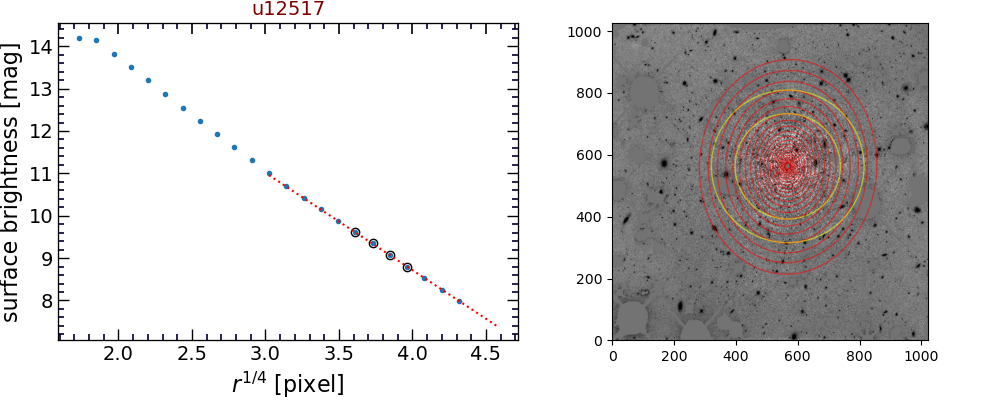

In [26]:
main_key = "second_elliprof"

# extracting parameter
# feel free to use other parameters too
r0 = obj.params[main_key]["r0"]
c_kron = obj.params[main_key]["c_kron"]
r1 = obj.outerR(c_kron)
k = obj.params[main_key]["k_ellipse"]
nr = int(np.round((r1 - r0) / k))
options = obj.params[main_key]["option"]

# plotting

axes = obj.plot_profile(sky_factor, r0, r1, nr, options=options, fit_imits=my_widget.value)

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: -21.92
Back Mean: -18.40
Back Stdev: 98.64
fig. name:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/u12517_updated_back.png

New potential sky factor: 0.894
Note that the suggested sky factor is determined based on the histogram of 
the background pixels in the residual image !!!


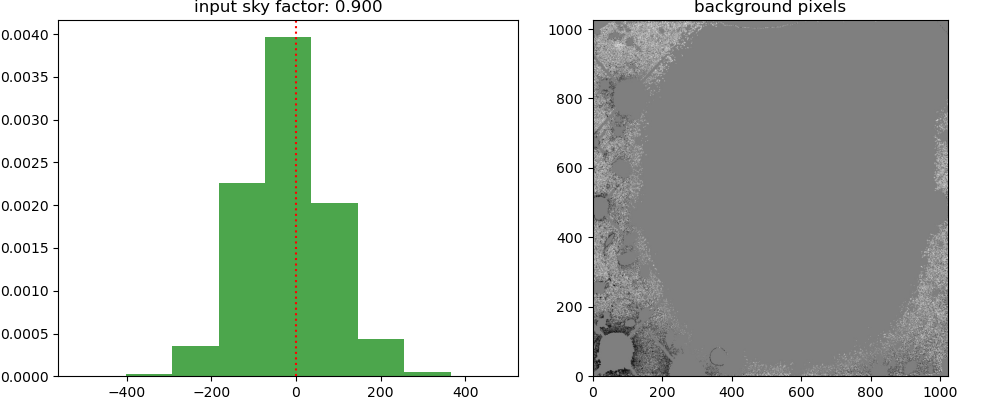

In [27]:
_ = obj.plot_back_histogram(sky_factor)

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [28]:
df = obj.save_log(sky_factor)

df

Log File:  /home/sbf/data_out/wfc3/Outputs_u12517/u12517_83b9b9191e35/../u12517_model_log.csv


,index,value,description
0,index,value,description
1,uuid,83b9b9191e35,Unique Identifier Code
2,User,Ehsan,User Name
3,Time,2025-03-10 03:19:10.413121,Modification Time
4,Name,u12517,Object Name
5,X_pixels,1022,X-dimension of image [pixel]
6,Y_pixels,1025,Y-dimension of image [pixel]
7,R_max,648,maximum horizontal/vertical distance from cent...
8,X0,567.6315,Object Center X0 [pixel]
9,Y0,562.6147,Object Center Y0 [pixel]
